<a href="https://colab.research.google.com/github/AlexeyRogS/cv_course/blob/main/week1/classic_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# План занятия:

Пространственная (spatial) обработка изображений:
* фильтры/свертка (filters/convolution)
* Blur
* Gaussian Blur
* Median Blur
* Sobel and Laplasian


Попиксельные (pixel-wise) преобразования изображения:
* работа с яркостью и контрастом
* гамма коррекция

Бинаризация и трешолдинг (image binarization and thresholding)
* Simple Thresholding
* Adaptive Thresholding

Морфологические операции (morphological operations)
* Erosion
* Dilation
* Opening
* Closing

In [ ]:
!pip install opencv-contrib-python matplotlib numpy

In [ ]:
import cv2
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML
from matplotlib import pyplot as plt

# Пространственная обработка изображений.





# Определение свертки

Свертка это бинарная математическая операция, определенная для двух матриц, на практике для изображения и ядра свертки, следующим образом. Пусть даны изображение f и ядро свертки w (размера aXb)

$g(x,y)=(w*f)(x,y)=\sum_{Δx=-a//2}^{a//2}\sum_{Δy=-b//2}^{b//2}w(a//2 + Δx,b//2 + Δy)f(x+Δx,y+Δy)$

Операция свертки проиллюстрирована на киртинке ниже. В действительности под сверткой могут пониматься много различных математических операций, изначально операция свертки возникла как метод обработки одномерных сигналов, потом заимствовалась и в другие области с разными модификациями.

Более правильная математическая формулировка свертки немного более запутанная, чем мы привели, она содержит транспонирование ядра свертки. Но на практике мы будем, как правило, работать со свертками в нейронных сетях, где свертки используются именно в соответствии с нашим определением.
<img src='https://neerc.ifmo.ru/wiki/images/thumb/7/71/Convolution_example.png/1200px-Convolution_example.png' />

## Blur
Попробуем понять, какую пользу могут нести свертки.
Начнем с самого простого, что только можно придумать.

In [ ]:
!mkdir -p input_files & wget "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png" -q -O ./input_files/lenna.png

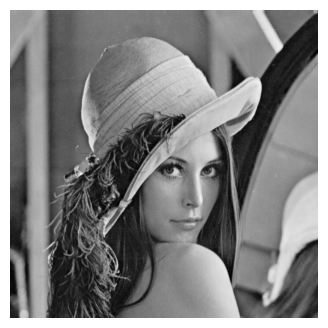

In [ ]:
img = cv2.imread('./input_files/lenna.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(gray, cmap='gray');

Зададим простой фильтр, состоящий из всех 1. А для того, чтобы при суммировании не произошло переполнения, добавим нормировочный коэффициент.


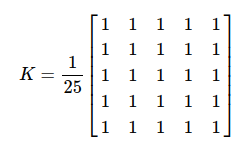

In [ ]:
kernel = np.ones((5, 5), dtype=float)
print(kernel)

kernel /= np.sum(kernel)
print(kernel)

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Для того, чтобы применить фильтр к изображению в OpenCV есть несколько методов. Для применения произвольного фильтра существует функция [cv2.filter2D()](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04)

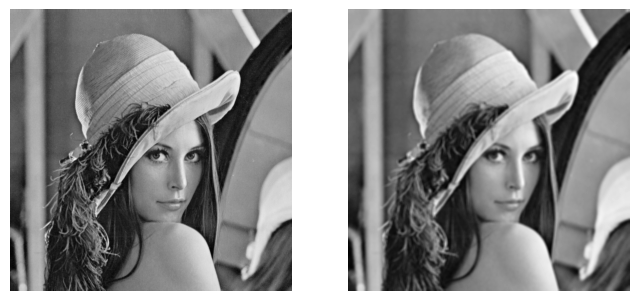

In [ ]:
blurred = cv2.filter2D(gray, -1, kernel)

figure, plots = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
for img, subplot in zip([gray, blurred], plots):
    subplot.imshow(img, cmap='gray')
    subplot.set_axis_off()
plt.show()

То же самое мы можем сделать и при помощи других функций. Например, [cv2.boxFilter()](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gad533230ebf2d42509547d514f7d3fbc3). Отличие состоит в том, что мы туда уже не передаем сами ядро. Оно создается автоматически. На самом деле аналогичную операцию выполняет и функция [cv2.blur()](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#ga8c45db9afe636703801b0b2e440fce37)

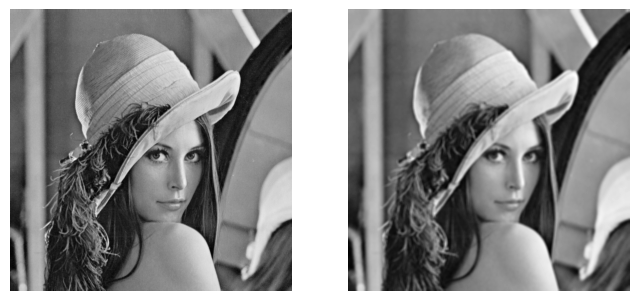

In [ ]:
img = cv2.imread('./input_files/lenna.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.blur(gray, (5, 5))

figure, plots = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
for img, subplot in zip([gray, blurred], plots):
    subplot.imshow(img, cmap='gray')
    subplot.set_axis_off()
plt.show()

### Как размер ядра будет влиять на степень размытия?

Чем большего будет размера ядро, тем сильнее будет размытие:

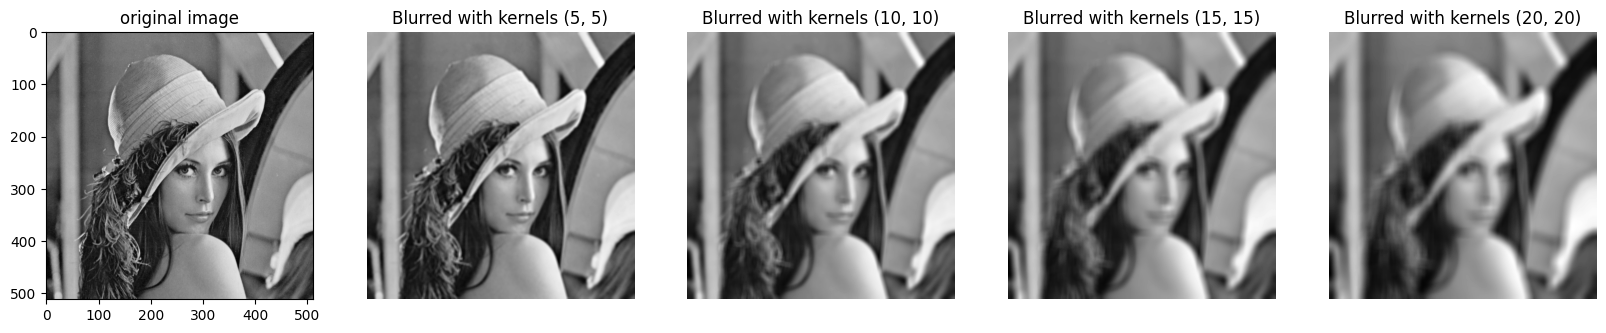

In [ ]:
image = cv2.imread('./input_files/lenna.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
N, step, kernel_size = 5, 5, 5

figure, axes = plt.subplots(ncols=N, nrows=1, figsize=(4*N, 4))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("original image")
for axe in axes[1:]:
    blurred = cv2.blur(image, (kernel_size, kernel_size))
    axe.imshow(blurred, cmap='gray')
    axe.set_title(f"Blurred with kernels {kernel_size,kernel_size}")
    axe.axis('off')
    kernel_size = kernel_size + step
plt.show()

## Gaussian Blur

Делает примерно то же самое, но использует вместо однородного ядра гауссово ядро. Для того, чтобы посмотреть, как оно выглядит можно воспользоваться функцией [cv2.getGaussianKernel()](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gac05a120c1ae92a6060dd0db190a61afa).

In [ ]:
gb = cv2.getGaussianKernel(3, 1)
gb

array([[0.27406862],
       [0.45186276],
       [0.27406862]])

$$g(x)=\frac{1}{\sigma\sqrt{2\pi}}\exp{\Biggl[-\frac{1}{2}\Biggl(\frac{x-\mu}{\sigma}\Biggr)^{2}\Biggr]}$$

$$g(x,y)=\frac{1}{2\pi\sigma^{2}}\exp{-\frac{1}{2}\frac{x^{2}+y^{2}}{\sigma^{2}}} = \frac{1}{\sigma\sqrt{2\pi}}\exp{-\frac{1}{2}\Biggl(\frac{x}{\sigma}\Biggr)^{2}} \cdot \frac{1}{\sigma\sqrt{2\pi}}\exp{-\frac{1}{2}\Biggl(\frac{y}{\sigma}\Biggr)^{2}}=g(x)g(y)$$

$$
\begin{pmatrix}
g(-1,-1) & g(-1,0) & g(-1,1)\\
g(0,-1) & g(0,0) & g(0,1) \\
g(1,-1) & g(1,0) & g(1,1)
\end{pmatrix}
=
\begin{pmatrix}
g(-1)g(-1) & g(-1)g(0) & g(-1)g(1)\\
g(0)g(-1) & g(0)g(0) & g(0)g(1) \\
g(1)g(-1) & g(1)g(0) & g(1)g(1)
\end{pmatrix}
=
\begin{pmatrix}
g(-1)\\
g(0)\\
g(1)
\end{pmatrix}
\begin{pmatrix}
g(-1) & g(0) & g(1)\\
\end{pmatrix}
$$

In [ ]:
def gauss(x, y, s):
    return np.exp(-0.5 * ((x**2 + y**2) / s**2)) / (2*np.pi * s**2)

def get_gb(s, kernel_size=3):
    assert kernel_size % 2 == 1
    g = np.zeros((kernel_size, kernel_size))
    for i in range(-kernel_size // 2, kernel_size // 2 + 1, 1):
        for j in range(-kernel_size // 2, kernel_size // 2 + 1, 1):
            g[i+kernel_size // 2,j+kernel_size // 2] = gauss(i, j, s)
    g = g / np.sum(g)
    return g
get_gb(1)

array([[0.07511361, 0.1238414 , 0.07511361],
       [0.1238414 , 0.20417996, 0.1238414 ],
       [0.07511361, 0.1238414 , 0.07511361]])

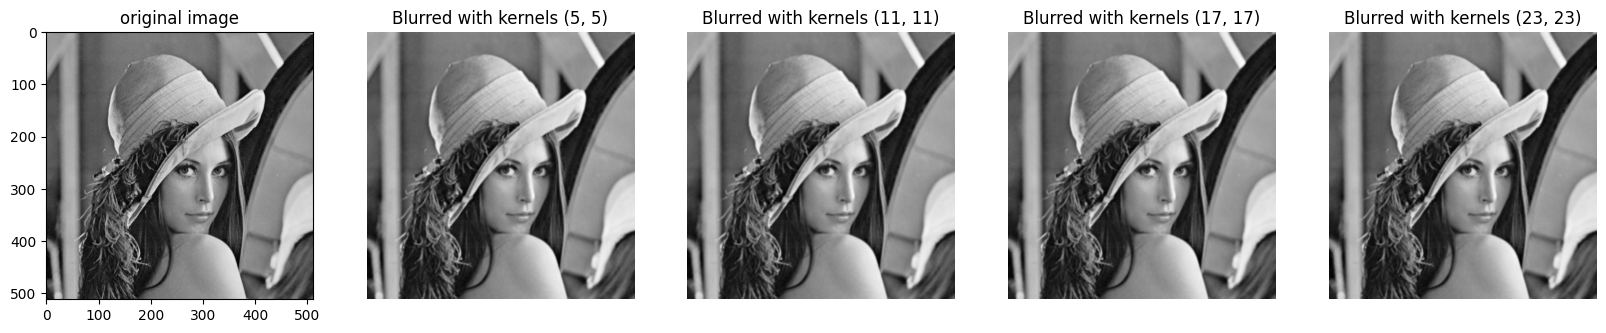

In [ ]:
image = cv2.imread('./input_files/lenna.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
N, step, kernel_size = 5, 5, 5

figure, axes = plt.subplots(ncols=N, nrows=1, figsize=(4*N, 4))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("original image")
for axe in axes[1:]:
    blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 1)
    axe.imshow(blurred, cmap='gray')
    axe.set_title(f"Blurred with kernels {kernel_size,kernel_size}")
    axe.axis('off')
    kernel_size = kernel_size + step
    kernel_size = kernel_size + kernel_size % 2 + 1  # must be odd
plt.show()

## Median blur

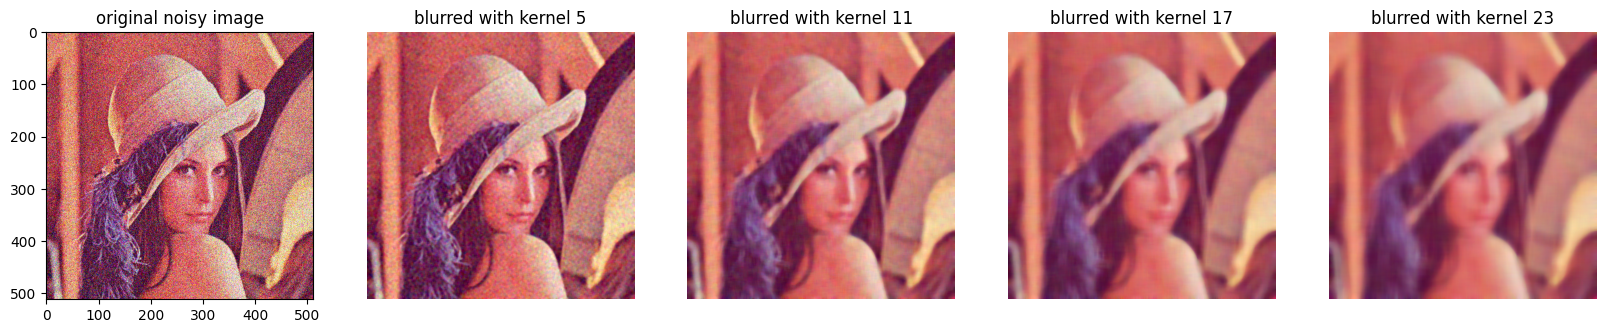

In [ ]:
image = cv2.imread('./input_files/lenna.png')[:,:,::-1]

mean = 0
sigma = 50
gauss = np.random.normal(mean, sigma, image.shape)
noisy = np.clip(image.astype(np.float32) + gauss, 0, 255).astype(np.uint8)

N, step, kernel_size = 5, 5, 5
figure, axes = plt.subplots(nrows=1, ncols=N, figsize=(4*N, 4))
axes[0].imshow(noisy)
axes[0].set_title("original noisy image")

for axe in axes[1:]:
    blurred = cv2.medianBlur(noisy, kernel_size)
    axe.imshow(blurred)
    axe.set_title(f"blurred with kernel {kernel_size}")
    axe.axis('off')
    kernel_size = kernel_size + step
    kernel_size = kernel_size + kernel_size % 2 + 1  # must be odd

## Sobel and Laplacian filtering

Фильтр собеля это объединяющий термин для фильтров, вычисляющих градиенты на изображении. Фильтры собеля очень полезны для детекции границ, ведь к границам принадлежат те пиксели, в которых происходит некий переход яркости, а значит и высокое значение градиента.

<img src="https://i.ibb.co/6ysDtS3/edge.png" height="300" width="900">

Для вычисления результата фильтра собеля можно использовать функцию [cv2.Sobel()](https://docs.opencv.org/4.5.3/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d) <br>
Она объединяет Гауссовское сглаживание и дифференцирование, при этом то, какие градиенты высчитываются, задается с помощью аргументов функции dx, dy.

$(dx,dy)=(1,0) → G_{x} \iff \frac{d}{dx}$  горизонтальные границы

$(dx,dy)=(0,1) → G_{y} \iff \frac{d}{dy}$  вертикальные границы

\begin{equation*}
Gx =
\begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
\end{equation*}

\begin{equation*}
Gy =
\begin{bmatrix}
-1 & -2 & -1\\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}
\end{equation*}

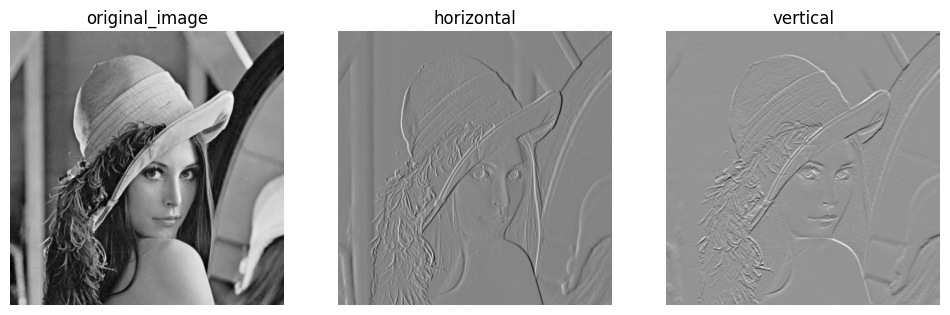

In [ ]:
image = cv2.imread('./input_files/lenna.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

horizontal = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
vertical = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

figure, axes = plt.subplots(ncols=3, nrows=1, figsize=(4*3, 4))
for axe, image, title in zip(axes, [image, horizontal, vertical], ['original_image', 'horizontal', 'vertical']):
    axe.imshow(image, cmap='gray')
    axe.set_title(title)
    axe.axis('off')
plt.show()

[cv2. Laplacian()](https://docs.opencv.org/4.5.3/d4/d86/group__imgproc__filter.html#gad78703e4c8fe703d479c1860d76429e6)

\begin{equation*}
L =
\begin{bmatrix}
0 & 1 & 0\\
1 & -4 & 1 \\
0 & 1 & 0
\end{bmatrix}
\end{equation*}

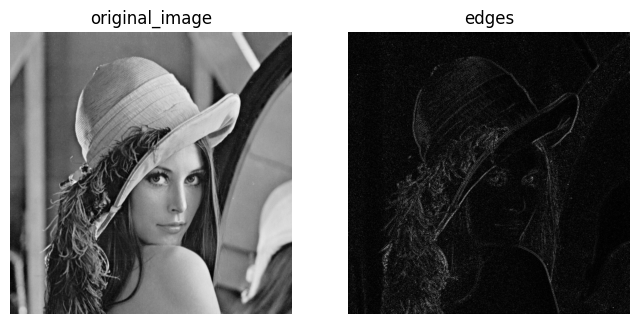

In [ ]:
image = cv2.imread('./input_files/lenna.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

lap = np.abs(cv2.Laplacian(image, cv2.CV_64F, ksize=1))

figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(4*2, 4))
for axe, img, title in zip(axes, [image, lap], ['original_image', 'edges']):
    axe.imshow(img
, cmap='gray')
    axe.set_title(title)
    axe.axis('off')
plt.show()

### Упражнение:
* Посчитать градиент изображения и нарисовать амплитуду градиента.

# Яркость, контраст и гамма коррекция

В отличие от пространственной обработки изображений преобразование яркости, контраста и гамма коррекции применяются к каждому пикселю индивидуально. Сейчас мы познакомимся с такими вещами, как гистограммы, изменение яркости, контраста, гамма коррекцией, LUT.



## Гистограммы

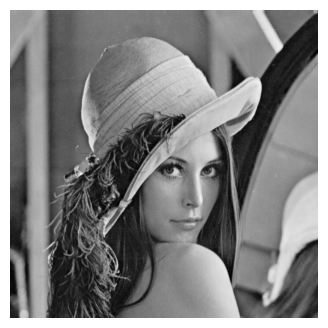

In [ ]:
img = cv2.imread('./input_files/lenna.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(gray, cmap='gray');

Как мы с вами можем вообще исследовать данное изображение? Одним из таких способов является гистограмма. Она показывает сколько пикселей с различной яркостью присутствует на изображении. [cv2.calcHist](https://www.geeksforgeeks.org/python-opencv-cv2-calchist-method/)

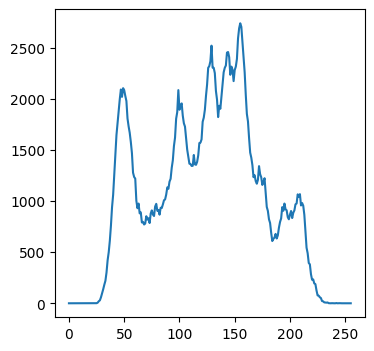

In [ ]:
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
plt.figure(figsize=(4, 4))
plt.plot(hist);

Аналагичную гистограмму можно построить и для цветной картинки по каждому каналу отдельно.

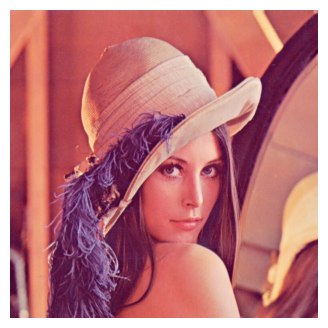

In [ ]:
img = cv2.imread('./input_files/lenna.png')[:,:,::-1]

plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(img);

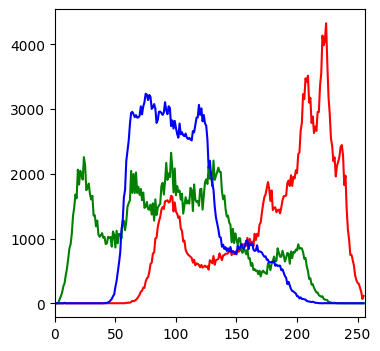

In [ ]:
color = ('red','green','blue')
plt.figure(figsize=(4, 4))
for i,col in enumerate(color):
    hist = cv2.calcHist([img], [i], None, [256], [0, 256])
    plt.plot(hist, color = col)
    plt.xlim([0,256])
plt.show()

## Яркость и контраст

Давайте вспомним, что изображение можно представить в виде функции
$f(x, y)$. Тогда мы можем применять к данной функции различные операции, в том числе сложение и умножение. Давайте зададим новое изображение по правилу:

$g(x, y) = a * f(x, y) + b$

Единственное, стоит учесть, что при выходе значения пикселя за границы [0, 255] нам надо его ограничить. Для этого существует функция np.clip(min, max), которая обрезает значения до заданного диапазона.

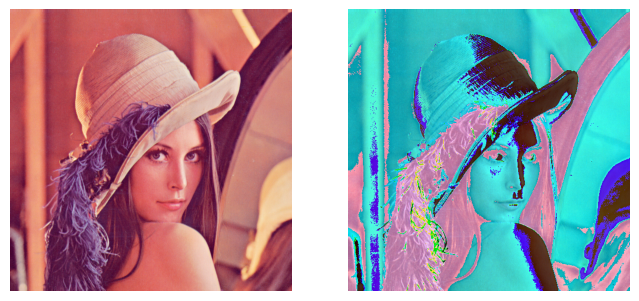

In [ ]:
alpha = 1
beta = 100

image = cv2.imread('./input_files/lenna.png')[:,:,::-1]
new_image = np.zeros_like(img)

new_image = np.clip(alpha * image + beta, 0, 255)
# new_image = new_image.astype(np.uint8)

figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
for img, axe in zip([image, new_image], axes):
    axe.imshow(img)
    axe.axis('off')
plt.show()

Существует и встроенная в opencv функция, реализующая эту же операцию

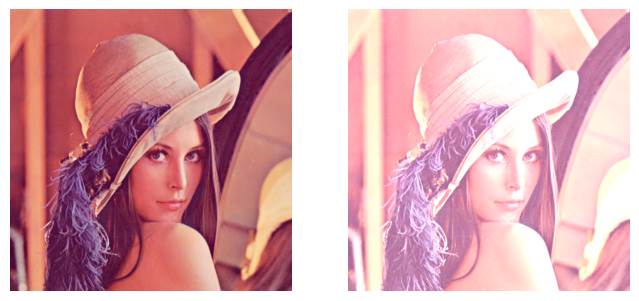

In [ ]:
alpha = 1
beta = 100

image = cv2.imread('./input_files/lenna.png')[:,:,::-1]
new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
for img, axe in zip([image, new_image], axes):
    axe.imshow(img)
    axe.axis('off')

plt.show()

Давайте посмотрим теперь на черно-белый вариант:

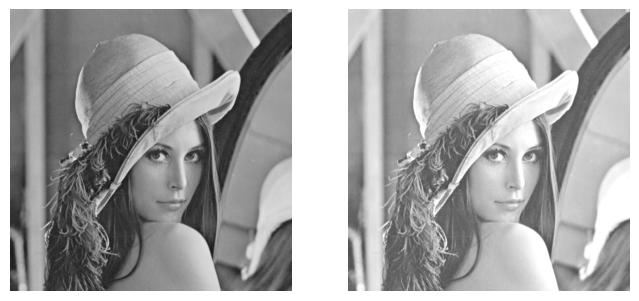

In [ ]:
alpha = 1
beta = 50

image = cv2.imread('./input_files/lenna.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
for img, axe in zip([image, new_image], axes):
    axe.imshow(img, cmap='gray', vmin=0, vmax=255)
    axe.axis('off')

plt.show()

Давайте теперь посмотрим на гистограммы:

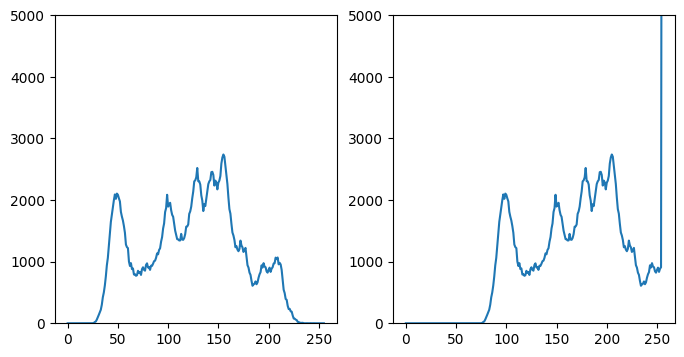

In [ ]:
figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
for img, axe in zip([image, new_image], axes):
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    axe.plot(hist)
    axe.set_ylim([0, 5000])
plt.show()

In [ ]:
image = cv2.imread('./input_files/lenna.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def update_plot(alpha, beta):
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    figure, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))
    for img, axe in zip([image, new_image], axes[0]):
        axe.imshow(img, cmap='gray', vmin=0, vmax=255)
        axe.axis('off')

    for img, axe in zip([image, new_image], axes[1]):
        hist = cv2.calcHist([img], [0], None, [256], [0, 256])
        axe.plot(hist)
        axe.set_ylim([0, 5000])
    plt.show()

alpha = widgets.FloatSlider(min=-2, max=3, value=1, description='alpha:')
beta = widgets.IntSlider(min=-500, max=255, value=0, description='beta:')

widgets.interactive(update_plot, alpha=alpha, beta=beta)

interactive(children=(FloatSlider(value=1.0, description='alpha:', max=3.0, min=-2.0), IntSlider(value=0, desc…

При отрицательных значениях параметра $beta$ у нас возникает странный эффект. Это происходит из-за взятия модуля модуля в функции [cv2.convertScaleAbs](https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga3460e9c9f37b563ab9dd550c4d8c4e7d). Можно вручную считать значения в пикселях, чтобы устранить этот эффект.

In [ ]:
image = cv2.imread('./input_files/lenna.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def update_plot(alpha, beta):
    new_image = np.clip(alpha * image + beta, 0, 255).astype(np.uint8)
    figure, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))
    for img, axe in zip([image, new_image], axes[0]):
        axe.imshow(img, cmap='gray', vmin=0, vmax=255)
        axe.axis('off')
    for img, axe in zip([image, new_image], axes[1]):
        hist = cv2.calcHist([img], [0], None, [256], [0, 256])
        axe.plot(hist)
        axe.set_ylim([0, 5000])
    plt.show()
alpha = widgets.FloatSlider(min=-2, max=3, value=1, description='alpha:')
beta = widgets.IntSlider(min=-255, max=255, value=0, description='beta:')
widgets.interactive(update_plot, alpha=alpha, beta=beta)

interactive(children=(FloatSlider(value=1.0, description='alpha:', max=3.0, min=-2.0), IntSlider(value=0, desc…

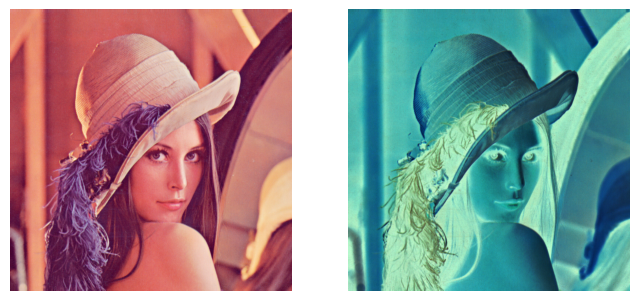

In [ ]:
alpha = 1
beta = 100

image = cv2.imread('./input_files/lenna.png')[:,:,::-1]
figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
for img, axe in zip([image, 255-image], axes):
    axe.imshow(img)
    axe.axis('off')

plt.show()

## LUT
В примерах выше мы для каждого значения пикселя применяли преобразование $a * x + b$. Но функции могут быть намного сложнее. Для того, чтобы не вычислять каждый раз значение в каждой точке существует LUT (Look up table).
Давайте вкратце рассмотрим, что это такое.

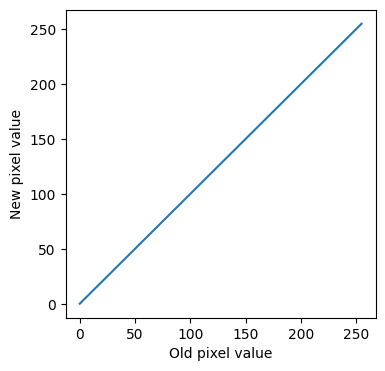

In [ ]:
look_up_table = np.arange(0, 256)

plt.figure(figsize=(4, 4))
plt.plot(look_up_table)
plt.xlabel('Old pixel value')
plt.ylabel('New pixel value')
plt.show()

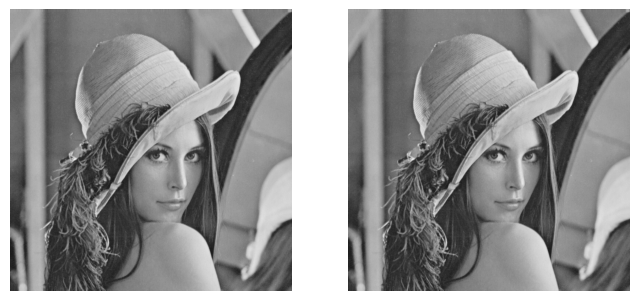

In [ ]:
image = cv2.imread('./input_files/lenna.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
new_image = cv2.LUT(image, look_up_table)

figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
for img, axe in zip([image, new_image], axes):
    axe.imshow(img, cmap='gray', vmin=0, vmax=255)
    axe.axis('off')

plt.show()

Это просто тождественное преобразование, так как мы по сути задали функцию $y = x$. Давайте вернемся к нашему примеру с $y = a * x + b$

In [ ]:
image = cv2.imread('./input_files/lenna.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def update_plot(alpha, beta):
    look_up_table = np.arange(0, 256)
    look_up_table = np.clip(alpha * look_up_table + beta, 0, 255).astype(np.uint8)

    new_image = cv2.LUT(image, look_up_table)

    figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
    for img, axe in zip([image, new_image], axes):
        axe.imshow(img, cmap='gray', vmin=0, vmax=255)
        axe.axis('off')
    figure, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
    for img, axe in zip([image, new_image], axes[:2]):
        hist = cv2.calcHist([img], [0], None, [256], [0, 256])
        axe.plot(hist)
        axe.set_ylim([0, 5000])
    axes[2].plot(look_up_table)
    axes[2].set_ylim([0, 260])
    plt.show()

alpha = widgets.FloatSlider(min=-2, max=3, value=1, description='alpha:')
beta = widgets.IntSlider(min=-255, max=255, value=0, description='beta:')
widgets.interactive(update_plot, alpha=alpha, beta=beta)

interactive(children=(FloatSlider(value=1.0, description='alpha:', max=3.0, min=-2.0), IntSlider(value=0, desc…

## Гамма коррекция.

Гамма коррекция задается по следующей формуле:

$$ O = (I / 255) ^ \gamma * 255$$

Где $I$ - исходное изображение, $O$ - преобразованное, $\gamma$ - непосредственно значение гаммы.

Давайте визуализируем LUT для гамма коррекции:

In [ ]:
def update_plot(gamma):
    look_up_table = np.clip((np.arange(0, 256) / 255.0)**gamma * 255.0, 0, 255)
    plt.figure(figsize=(4, 4))
    plt.plot(look_up_table)
    plt.xlabel('Old pixel value')
    plt.ylabel('New pixel value')
    plt.show()

gamma = widgets.FloatSlider(min=0.001, max=25, value=1, description='gamma:')
widgets.interactive(update_plot, gamma=gamma)

interactive(children=(FloatSlider(value=1.0, description='gamma:', max=25.0, min=0.001), Output()), _dom_class…

In [ ]:
image = cv2.imread('./input_files/lenna.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def update_plot(gamma):
    look_up_table = np.clip((np.arange(0, 256) / 255.0)**gamma * 255.0, 0, 255).astype(np.uint8)
    new_image = cv2.LUT(image, look_up_table)
    figure, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
    for img, axe in zip([image, new_image], axes[:2]):
        axe.imshow(img, cmap='gray', vmin=0, vmax=255)
        axe.axis('off')
    axes[2].plot(look_up_table)
    axes[2].set_ylim([0, 260])
    axes[2].set_xlim([0, 260])
    plt.show()
gamma = widgets.FloatSlider(min=0.001, max=4, value=1, description='gamma:')
widgets.interactive(update_plot, gamma=gamma)

interactive(children=(FloatSlider(value=1.0, description='gamma:', max=4.0, min=0.001), Output()), _dom_classe…

In [ ]:
image = cv2.imread('./input_files/lenna.png')[:,:,::-1]

def update_plot(gamma):
    look_up_table = np.clip((np.arange(0, 256) / 255.0)**gamma * 255.0, 0, 255).astype(np.uint8)
    new_image = cv2.LUT(image, look_up_table)
    figure, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
    for img, axe in zip([image, new_image], axes[:2]):
        axe.imshow(img)
        axe.set_axis_off()
    axes[2].plot(look_up_table)
    axes[2].set_ylim([0, 260])
    axes[2].set_xlim([0, 260])
    plt.show()
gamma = widgets.FloatSlider(min=0.001, max=4, value=1, description='gamma:')
widgets.interactive(update_plot, gamma=gamma)

interactive(children=(FloatSlider(value=1.0, description='gamma:', max=4.0, min=0.001), Output()), _dom_classe…

# Бинаризация и трешолдинг

Бинаризация изображения, это процесс, когда мы каждому пикселю присваиваем значение либо 0, либо 1 (иногда можно 255).

Трешолдинг или пороговое преобразование, это когда мы задаем порог и какое-то правило, по которому в соответствие с заданным порогом меняем значения изображения.

## Simple Thresholding  

In [ ]:
np.tile(np.arange(0, 3), (3, 2))

array([[0, 1, 2, 0, 1, 2],
       [0, 1, 2, 0, 1, 2],
       [0, 1, 2, 0, 1, 2]])

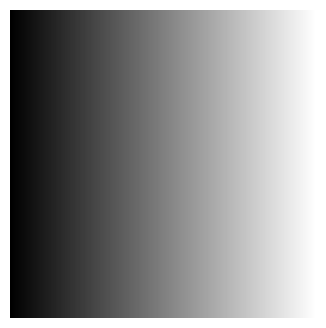

In [ ]:
image = np.tile(np.arange(0, 255), (256, 1)).astype(np.uint8)
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(image, cmap='gray');

Давайте рассмотрим, какие функции нам предоставляет opencv:
Самое простое это [cv2.threshold()](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57)

In [ ]:
def update_plot(threshold):
    ret, thresh_binary = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
    for img, axe in zip([image, thresh_binary], axes):
        axe.imshow(img, cmap='gray')
    plt.show()
threshold = widgets.IntSlider(min=0, max=255, value=0,  description='threshold:')
widgets.interactive(update_plot, threshold=threshold)

interactive(children=(IntSlider(value=0, description='threshold:', max=255), Output()), _dom_classes=('widget-…

In [ ]:
def update_plot(threshold):
    ret, thresh_binary = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY_INV)
    figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
    for img, axe in zip([image, thresh_binary], axes):
        axe.imshow(img, cmap='gray')
    plt.show()
threshold = widgets.IntSlider(min=0, max=255, value=0,  description='threshold:')
widgets.interactive(update_plot, threshold=threshold)

interactive(children=(IntSlider(value=0, description='threshold:', max=255), Output()), _dom_classes=('widget-…

In [ ]:
def update_plot(threshold):
    ret, thresh_binary = cv2.threshold(image, threshold, 255, cv2.THRESH_TRUNC)
    figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
    for img, axe in zip([image, thresh_binary], axes):
        axe.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()
threshold = widgets.IntSlider(min=0, max=255, value=0,  description='threshold:')
widgets.interactive(update_plot, threshold=threshold)

interactive(children=(IntSlider(value=0, description='threshold:', max=255), Output()), _dom_classes=('widget-…

In [ ]:
def update_plot(threshold):
    ret, thresh_binary = cv2.threshold(image, threshold, 255, cv2.THRESH_TOZERO)
    figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
    for img, axe in zip([image, thresh_binary], axes):
        axe.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()
threshold = widgets.IntSlider(min=0, max=255, value=0,  description='threshold:')
widgets.interactive(update_plot, threshold=threshold)

interactive(children=(IntSlider(value=0, description='threshold:', max=255), Output()), _dom_classes=('widget-…

In [ ]:
def update_plot(threshold):
    ret, thresh_binary = cv2.threshold(image, threshold, 255, cv2.THRESH_TOZERO_INV)
    figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
    for img, axe in zip([image, thresh_binary], axes):
        axe.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

threshold = widgets.IntSlider(min=0, max=255, value=0,  description='threshold:')
widgets.interactive(update_plot, threshold=threshold)

interactive(children=(IntSlider(value=0, description='threshold:', max=255), Output()), _dom_classes=('widget-…

## Adaptive Thresholding

In [ ]:
!wget "https://www.quickdrawsupplies.com/wp-content/uploads/2022/08/4155-3.jpg" -q -O ./input_files/sudoku.jpg

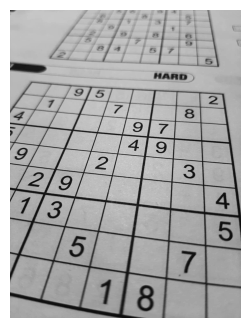

In [ ]:
img = cv2.imread('./input_files/sudoku.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(gray, cmap='gray');

In [ ]:
def update_plot(threshold):
    ret, thresh_binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
    for img, axe in zip([gray, thresh_binary], axes):
        axe.imshow(img, cmap='gray')
    plt.show()

threshold = widgets.IntSlider(min=0, max=255, value=0, description='threshold:')
widgets.interactive(update_plot, threshold=threshold)

interactive(children=(IntSlider(value=0, description='threshold:', max=255), Output()), _dom_classes=('widget-…

In [ ]:
def update_plot(kernel_size, c):
    threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, kernel_size, c)
    figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
    for img, axe in zip([gray, threshold], axes):
        axe.imshow(img, cmap='gray')
    plt.show()
kernel_size = widgets.IntSlider(min=3, max=255, value=3, step=2, description='kernel_size:')
c = widgets.IntSlider(min=0, max=255, value=0, step=1, description='c:')
widgets.interactive(update_plot, kernel_size=kernel_size, c=c)

interactive(children=(IntSlider(value=3, description='kernel_size:', max=255, min=3, step=2), IntSlider(value=…

In [ ]:
def update_plot(kernel_size, c):
    threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, kernel_size, c)
    figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
    for img, axe in zip([gray, threshold], axes):
        axe.imshow(img, cmap='gray')
    plt.show()

kernel_size = widgets.IntSlider(min=3, max=255, value=3, step=2, description='kernel_size:')
c = widgets.IntSlider(min=0, max=255, value=0, step=1, description='c:')
widgets.interactive(update_plot, kernel_size=kernel_size, c=c)

interactive(children=(IntSlider(value=3, description='kernel_size:', max=255, min=3, step=2), IntSlider(value=…

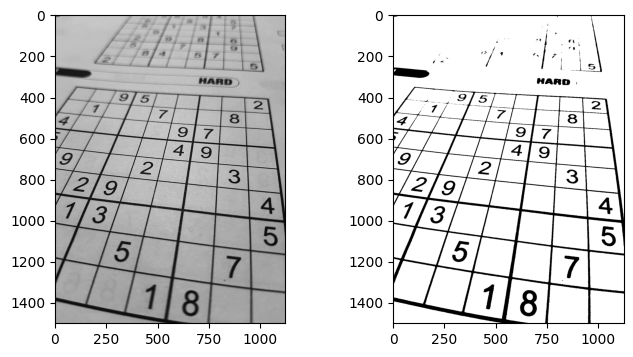

In [ ]:
_, threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
for img, axe in zip([gray, threshold], axes):
    axe.imshow(img, cmap='gray')
plt.show()

# Морфологические операции
В биологии ***морфология*** занимается формой и строением животных и растений. В нашем же случае будет использоваться *математическая морфология* —  теория и техника анализа и обработки геометрических структур, основанная на теории множеств, топологии и случайных функциях.


В данном уроке мы познакомимся с основными морфологическими операциями.
В морфологических операциях всегда присутствуют две составляющие: исходное бинарное изображение и структурный элемент или примитив.

В качестве исходного множества у нас будет вот такой смайлик (здесь мы видим не бинарное изображение, но это сделано для наглядности):

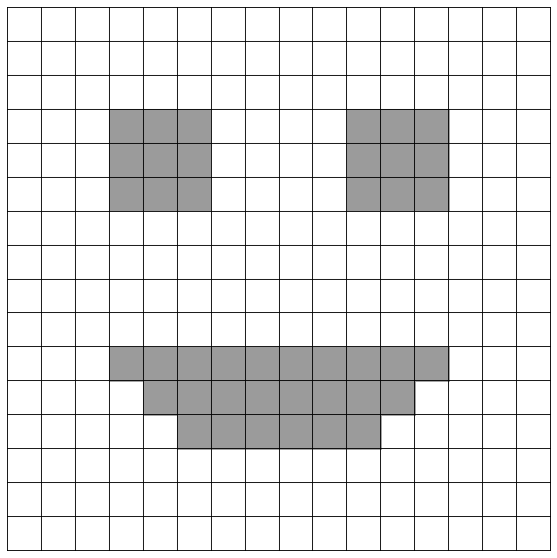

А в качестве структурного элемента будет вот такой крестик:

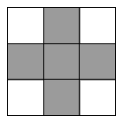

Давайте сразу начнем с примеров, чтобы лучше разобраться. Для более глубокого изучения темы и для определений в терминах теории множеств настоятельно рекомендую посмотреть список дополнительной литературы.

📚 Список литературы по данной теме

- [Цифровая обработка изображений | Гонсалес Рафаэль, Вудс Ричард](https://www.ozon.ru/product/tsifrovaya-obrabotka-izobrazheniy-gonsales-rafael-vuds-richard-242389345/?sh=ZNJzjW5E&utm_source=google&utm_medium=cpc&utm_campaign=RF_Regstore_Product_DSA_NewClients&gclid=Cj0KCQjw8p2MBhCiARIsADDUFVF3HEhYSOdzOa4Wtw7NH1rZiDgX6pZt67qSx2P8WziU2zPP_kvTd9YaAtJAEALw_wcB) глава 9.
- Вот этот [сайт](https://homepages.inf.ed.ac.uk/rbf/HIPR2/morops.htm)
- Документация [OpenCV](https://docs.opencv.org/4.5.3/dd/dd7/tutorial_morph_lines_detection.html)

## Эрозия

Создадим пустую картинку такого же размера, как и исходная:

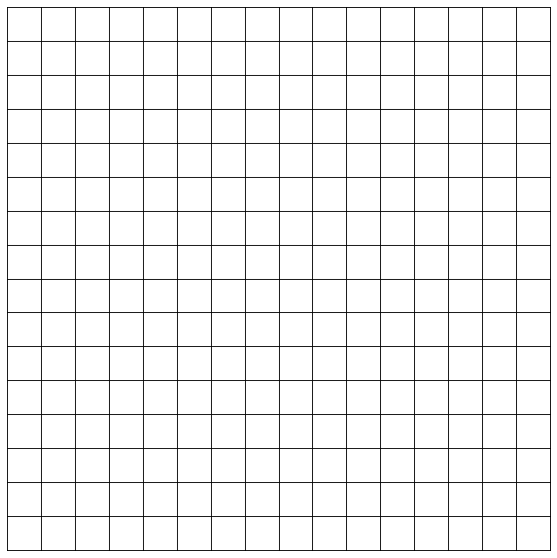

Давайте начнем перемещать центр нашего примитива по исходному изображению таким образом, чтобы он накладывался на каждый пиксель нашего смайлика.

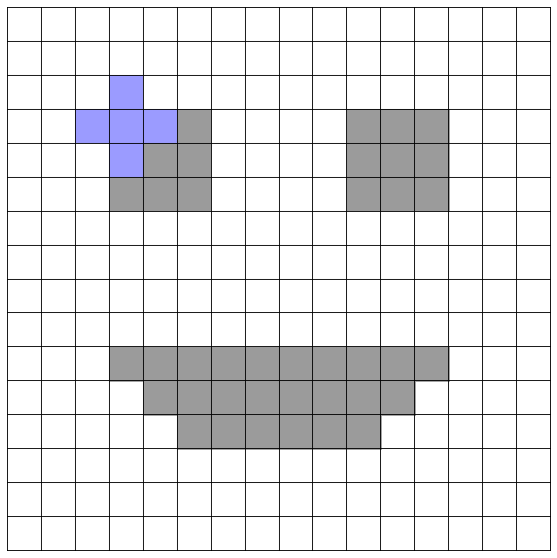

Если при этом весь примитив содержится в исходном множестве, то местоположение этого центра будет закрашено в результирующей картинке. Если нет, то остается пустым (черным) пикселем.

В данном случае у нас два элемента примитива оказались вне смайлика:

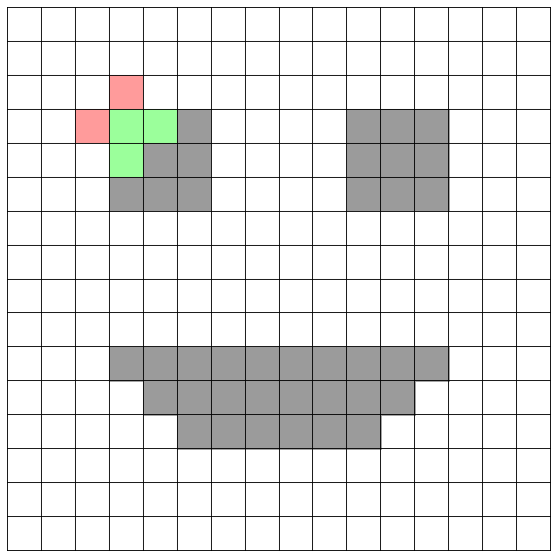

Поэтому мы переходим дальше. Пройдясь по всему левому глазу мы обнаружим, что только в центре будет выполняться указанное выше условие:

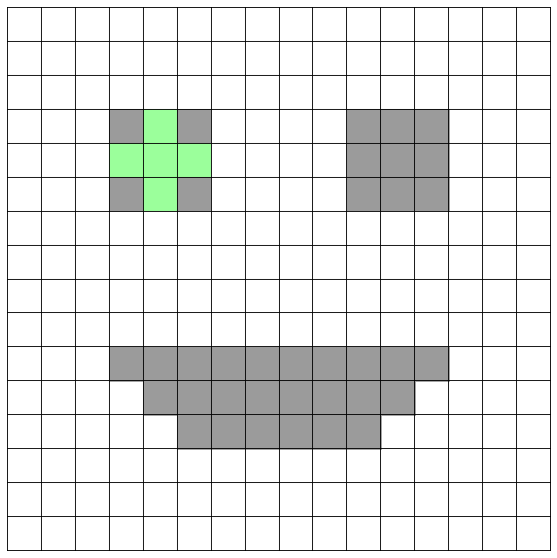

Значит в результирующее множество для левого глаза попадет только центральный пиксель.

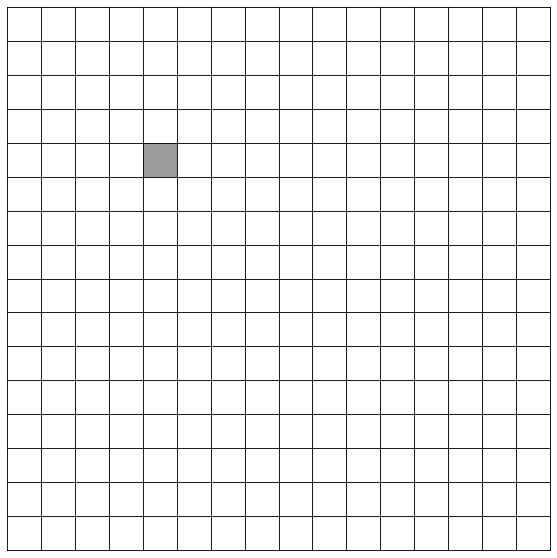

Поступим аналогично с правым глазом и улыбкой:

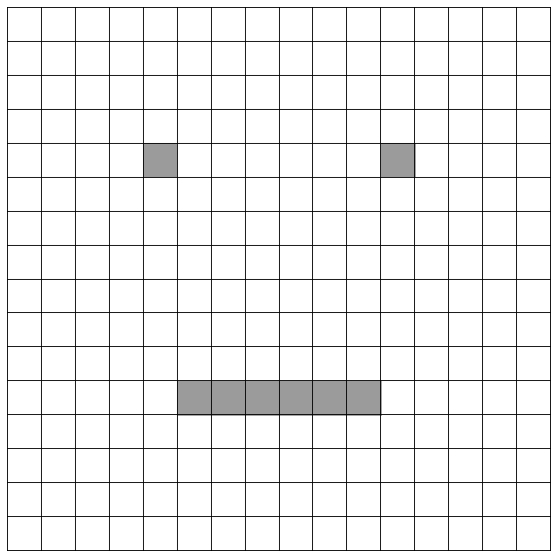

Хммм, кажется, что наш друг чем-то недоволен? Да мы же только что применили к нему эрозию! Кому такое понравится?

Давайте теперь посмотрим, как мы можем провернуть такое же при помощи OpenCV? Для этого в библиотеке присутствует функция [cv2.erode()](https://docs.opencv.org/4.5.3/d4/d86/group__imgproc__filter.html#gaeb1e0c1033e3f6b891a25d0511362aeb). Давайте воспользуемся ей:

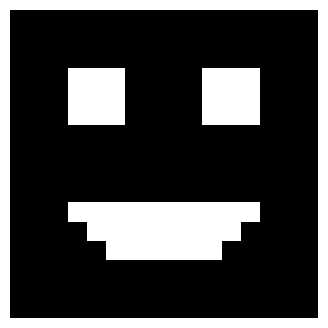

In [ ]:
# создаем смайлик (придется вручную, но ничего страшного)

def create_smile():
    smile = np.zeros((16, 16), dtype=np.uint8)
    smile[3:6, 3:6] = 255
    smile[3:6, 10:13] = 255
    smile[10:11, 3:13] = 255
    smile[11:12, 4:12] = 255
    smile[12:13, 5:11] = 255
    return smile

smile = create_smile()

plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(smile, cmap='gray');

Да, на бинарном изображении он выглядит не так весело, как раньше, но ничего страшного. Нам осталось задать примитив и применить эрозию:

In [ ]:
kernel = np.zeros((3,3), np.uint8)
kernel[1,:] = 1
kernel[:,1] = 1
kernel

array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]], dtype=uint8)

Вам тоже не нравится данный фрагмент кода, где мы закрашиваем вручную белые части на нашем структурном элементе? К счастью, в OpenCV есть функция [cv2.getStructuringElement()](https://docs.opencv.org/4.5.3/d4/d86/group__imgproc__filter.html#gac342a1bb6eabf6f55c803b09268e36dc). С ее помощью мы можем получить различные примитивы. Нам на выбор доступны прямоугольники, крестики и эллипсы.

In [ ]:
rectangle = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
for m in [rectangle, ellipse, cross]:
    print(m)
    print('=============')

[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
[[0 0 1 0 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [0 0 1 0 0]]
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]


Давайте теперь вернемся к нашему смайлику и применим к нему эрозию:

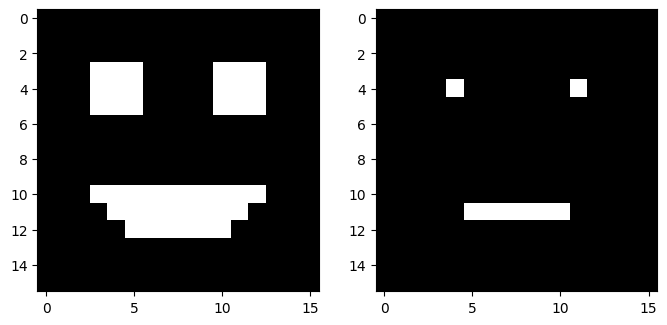

In [ ]:
smile = create_smile()
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
erosion = cv2.erode(smile, kernel, iterations=1)
figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
for img, axe in zip([smile, erosion], axes):
    axe.imshow(img, cmap='gray')
plt.show()

## Упражнение

Поиграемся с различными структурными элементами и смайликом. Попробуйте применить различные структурные элементы (квадрат, круг, линию) и посмотреть, как изменится смайлик.

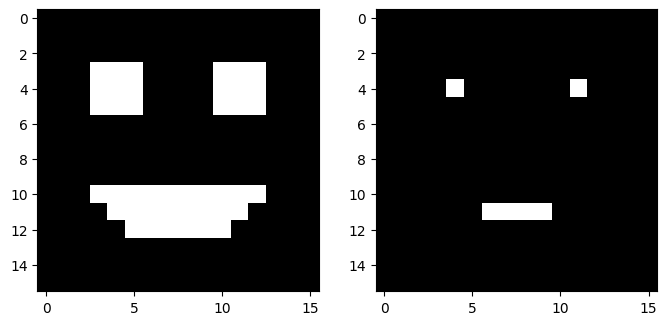

In [ ]:
smile = create_smile()
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
erosion = cv2.erode(smile, kernel, iterations=1)

figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))

for img, axe in zip([smile, erosion], axes):
    axe.imshow(img, cmap='gray')
plt.show()

## Дилатация

Дилатация противоположна эрозии. Начнем все с того же. Создадим пустое изображение, куда будем помещать результаты работы.

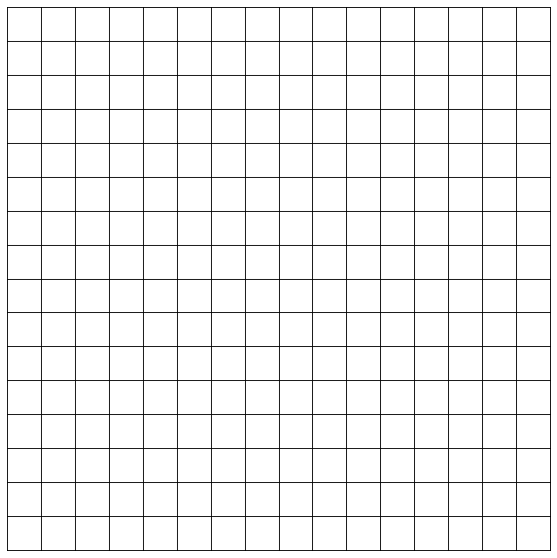

Далее также начнем проходиться центром нашего примитива по пикселям исходной картинки. При этом мы будем закрашивать в результирующем изображении все те пиксели, на которых лежит примитив, если он имеет хотя бы одну точку пересечения с ненулевыми пикселями исходного изображения:

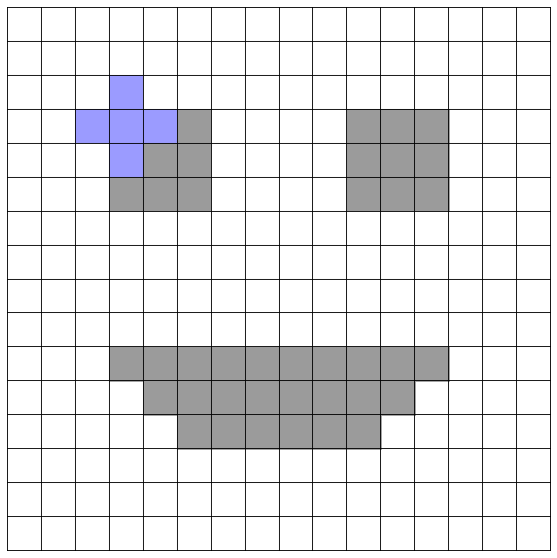

Здесь все отлично, поэтому в результирующее изображение мы добавляем крестик на текущей позиции.

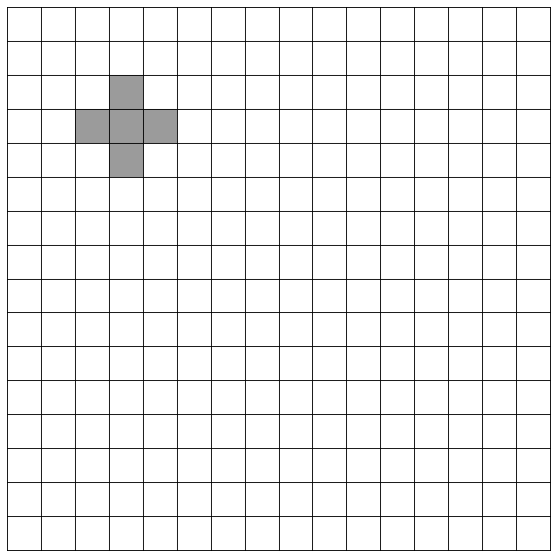

Проходясь таким образом по всему изображению мы достигнем следующего результата:

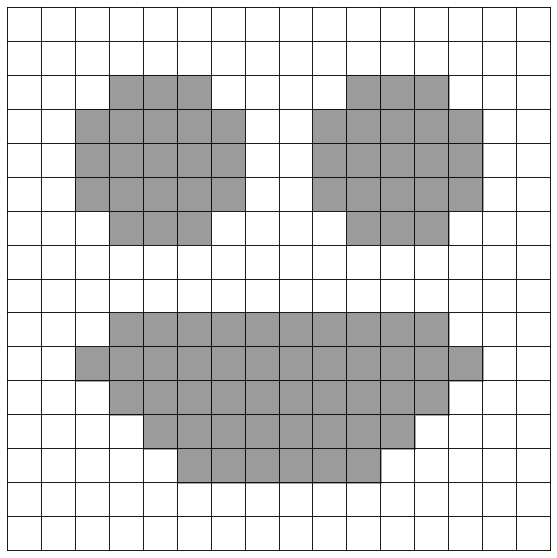

В OpenCV дилатация представлена функцией [cv2.dilate()](https://docs.opencv.org/4.5.3/d4/d86/group__imgproc__filter.html#ga4ff0f3318642c4f469d0e11f242f3b6c).

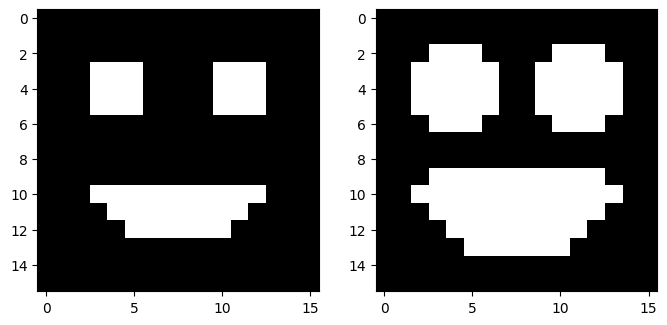

In [ ]:
smile = create_smile()
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
dilation = cv2.dilate(smile, kernel, iterations=1)

figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
for img, axe in zip([smile, dilation], axes):
    axe.imshow(img, cmap='gray')
plt.show()

## Упражнение

Попробуйте догадаться, как нам применить дилатацию, чтобы получить эрозию и наоборот?


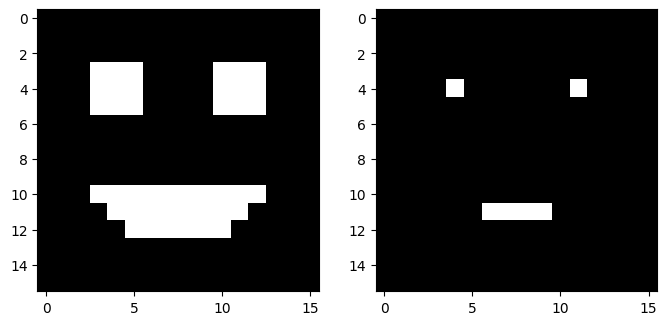

In [ ]:
smile = create_smile()
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
# erosion = # что-то другое, но не эрозия

figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))

for img, axe in zip([smile, erosion], axes):
    axe.imshow(img, cmap='gray')
plt.show()

## Opening (размыкание)

Выше мы могли заметить, что дилатация приводит к расширению деталей на изображении, а эрозия — к их сужению.

Давайте теперь попробуем применить сначала эрозию, а затем дилатацию и посмотреть на результат:

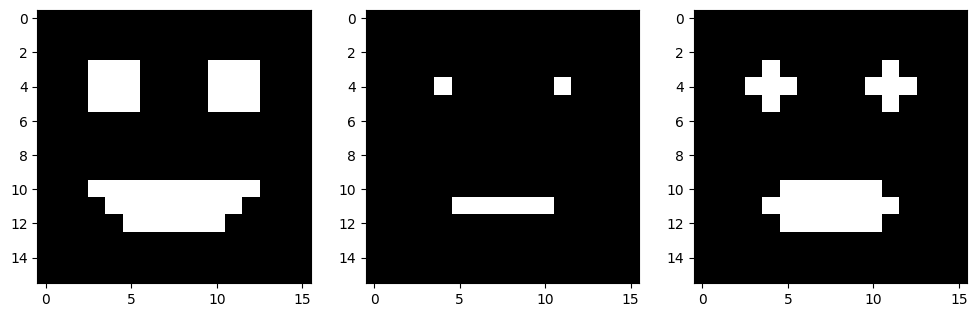

In [ ]:
smile = create_smile()
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3), anchor=(1, 1))

erosion = cv2.erode(smile, kernel, iterations=1)
opening = cv2.dilate(erosion, kernel, iterations=1)

figure, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))

for img, axe in zip([smile, erosion, opening], axes):
    axe.imshow(img, cmap='gray')
plt.show()

Получается, что одна операция это по сути поочередное применение двух других. Неужели нам придется писать каждый раз их поочередно? К счастью, в OpenCV есть функция [cv2.morphologyEx()](https://docs.opencv.org/4.5.3/d4/d86/group__imgproc__filter.html#ga67493776e3ad1a3df63883829375201f). Она позволяет указать нам какую морфологическую операцию применить к изображению. Это можно задать при помощи следующих [флагов](https://docs.opencv.org/4.5.3/d4/d86/group__imgproc__filter.html#ga7be549266bad7b2e6a04db49827f9f32):
- cv2.MORPH_ERODE
- cv2.MORPH_DILATE
- cv2.MORPH_OPEN
- cv2.MORPH_CLOSE
- cv2.MORPH_GRADIENT
- cv2.MORPH_TOPHAT
- cv2.MORPH_BLACKHAT
- cv2.MORPH_HITMISS


То есть код выше мы можем переписать таким образом:


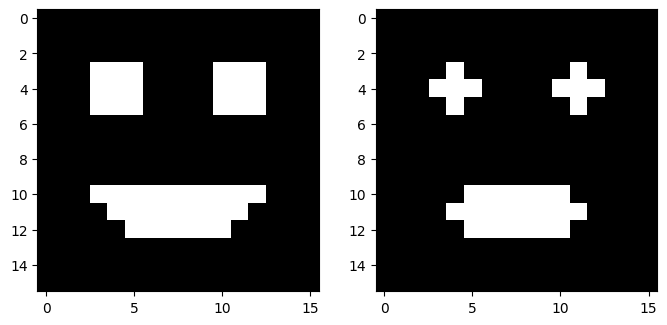

In [ ]:
smile = create_smile()
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3), anchor=(1, 1))
opening = cv2.morphologyEx(smile, cv2.MORPH_OPEN, kernel)

figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
for img, axe in zip([smile, opening], axes):
    axe.imshow(img, cmap='gray')
plt.show()

В чем же смысл операции opening? К ней следует относиться таким образом, что она сначала удаляет мелкий шум или размыкает исходное множество, при этом не сильно меняя его. Давайте добавим немного шума на наш смайлик и применим эту операцию:

In [ ]:
!wget https://docs.opencv.org/4.x/j.png -q -O ./input_files/j.png

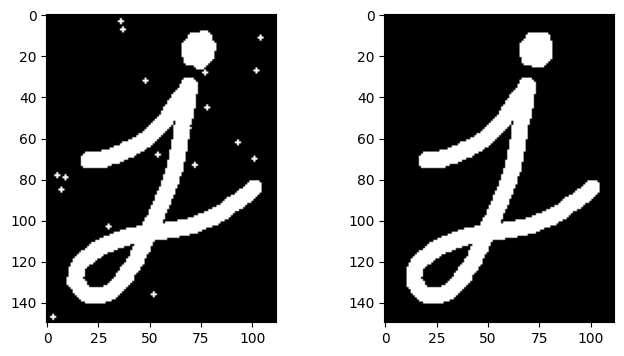

In [ ]:
image = cv2.imread('./input_files/j.png', cv2.IMREAD_GRAYSCALE)
N = 20  # draw 20 random circles
xx = np.random.randint(0, image.shape[1], (N,))
yy = np.random.randint(0, image.shape[0], (N,))
for x, y in zip(xx, yy):
    cv2.circle(image, (x,y), 1, (255, 255, 255), -1)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5), anchor=(1, 1))
opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
for img, axe in zip([image, opening], axes):
    axe.imshow(img, cmap='gray')
plt.show()

Теперь представим, что глаза у смайлика соединены линией, которая нам особо и не нужна. Применим opening и посмотрим на результат:

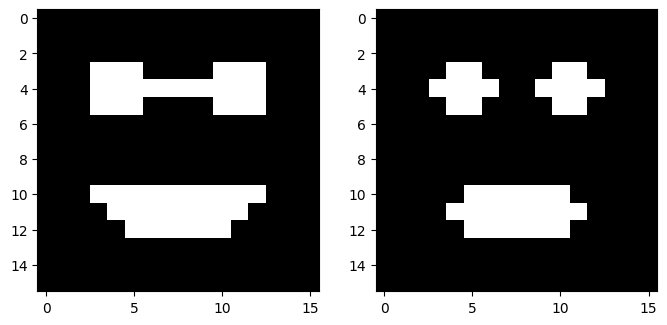

In [ ]:
smile = create_smile()
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
smile[4, 4:11] = 255
opening = cv2.morphologyEx(smile, cv2.MORPH_OPEN, kernel)
figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
for img, subplot in zip([smile, opening], axes):
    subplot.imshow(img, cmap='gray')
plt.show()

Давайте еще разок посмотрим на результат работы размыкания, но уже на другой фигуре.

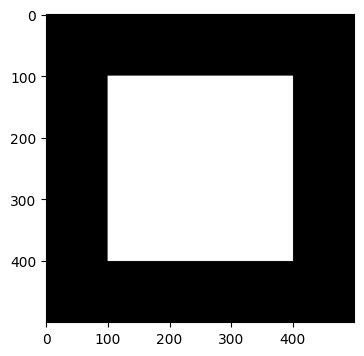

In [ ]:
image = np.zeros((500, 500), dtype=np.uint8)
image = cv2.rectangle(image, (100, 100),(400, 400), 255, -1)

plt.figure(figsize=(4, 4))
plt.imshow(image, cmap='gray');

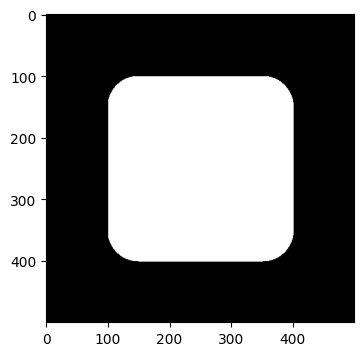

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (100, 100))
opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(4, 4))
plt.imshow(opening, cmap='gray');

## Closing (замыкание)

Как вы могли догадаться, замыкание это ни что иное, как применение тех же операций дилатации и эрозии, но уже в другом порядке:

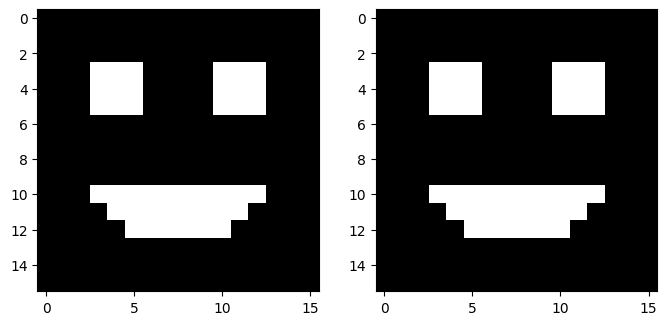

In [ ]:
smile = create_smile()
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
closing = cv2.morphologyEx(smile, cv2.MORPH_CLOSE, kernel)
figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))

for img, axe in zip([smile, closing], axes):
    axe.imshow(img, cmap='gray')
plt.show()

Шума такой операцией уже, очевидно, убрать не получится

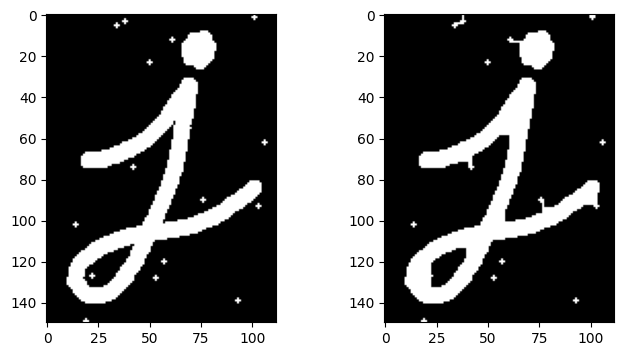

In [ ]:
image = cv2.imread('./input_files/j.png', cv2.IMREAD_GRAYSCALE)
N = 20  # draw 20 random circles
xx = np.random.randint(0, image.shape[1], (N,))
yy = np.random.randint(0, image.shape[0], (N,))
for x, y in zip(xx, yy):
    cv2.circle(image, (x,y), 1, (255, 255, 255), -1)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5), anchor=(1, 1))
closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
for img, axe in zip([image, closing], axes):
    axe.imshow(img, cmap='gray')
plt.show()

Но эта операций отлично подходит для устранения каких-то мелких "дырок" внутри объекта на изображении

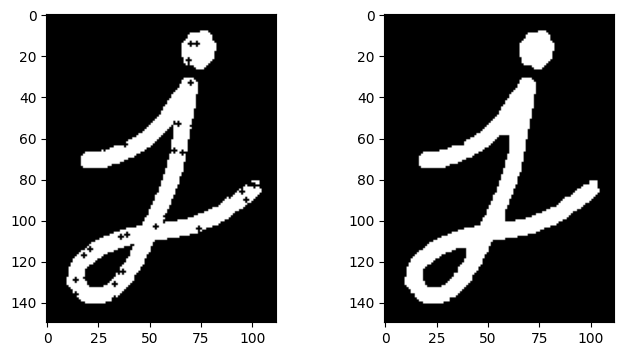

In [ ]:
image = cv2.imread('./input_files/j.png', cv2.IMREAD_GRAYSCALE)
N = 200  # draw 20 random circles
xx = np.random.randint(0, image.shape[1], (N,))
yy = np.random.randint(0, image.shape[0], (N,))
for x, y in zip(xx, yy):
    cv2.circle(image, (x,y), 1, (0, 0, 0), -1)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5), anchor=(1, 1))
closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
figure, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
for img, axe in zip([image, closing], axes):
    axe.imshow(img, cmap='gray')
plt.show()

Вернемся к квадрату.

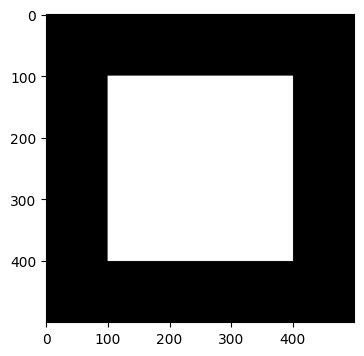

In [ ]:
image = np.zeros((500, 500), dtype=np.uint8)
image = cv2.rectangle(image, (100, 100),(400, 400), 255, -1)

plt.figure(figsize=(4, 4))
plt.imshow(image, cmap='gray');

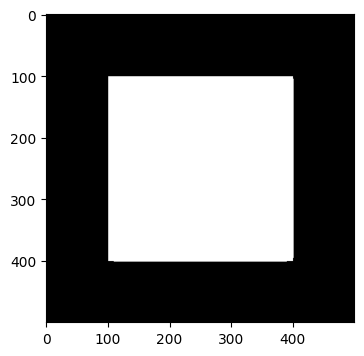

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (100, 100))
opening = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)


plt.figure(figsize=(4, 4))
plt.imshow(opening, cmap='gray');

Странно, особо сильно он не изменился. Это не совсем то, чего вы могли ожидать. Давайте немного модифицируем исходный квадрат и добавим разрыв.

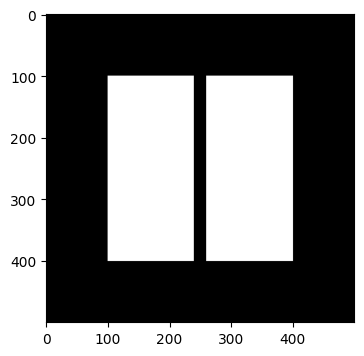

In [ ]:
image = np.zeros((500, 500), dtype=np.uint8)
image = cv2.rectangle(image, (100, 100),(400, 400), 255, -1)
image[:,240:260] = 0

plt.figure(figsize=(4, 4))
plt.imshow(image, cmap='gray');

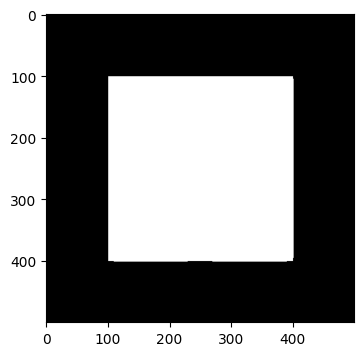

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (100, 100))
opening = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)


plt.figure(figsize=(4, 4))
plt.imshow(opening, cmap='gray');

## Упражнение
Я хочу научить компьютер играть на фортепиано вместо меня. У меня есть вот такой врагмент нот:
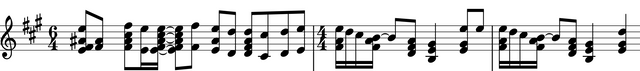


Очевидно, что в данном уроке мы не будем учиться разбираться, где какая нота. Но давайте поможем компьютеру отделить нотный стан от самих нот. Для этого достаточно использовать то, что мы уже изучали с вами на этом уроке.

In [ ]:
!mkdir -p input_files & wget "https://i.ibb.co/17MgLBP/image.png" -q -O ./input_files/music.png

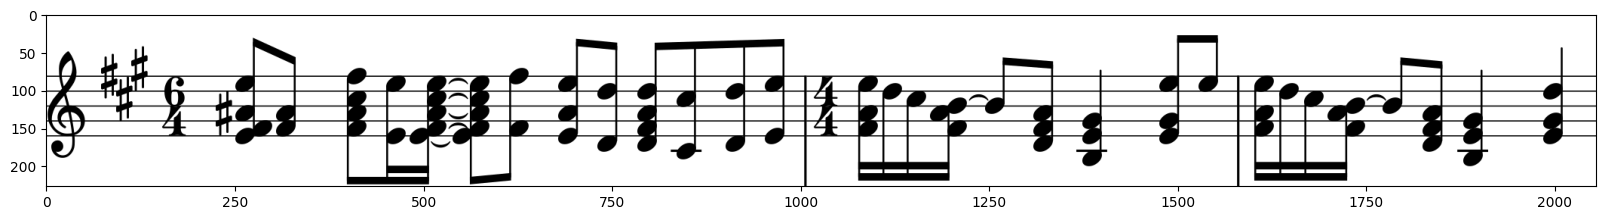

In [ ]:
music = cv2.imread('./input_files/music.png')
music = cv2.cvtColor(music, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(20, 10))
plt.imshow(music, cmap='gray');

Здесь напрашивается следующий алгоритм:
- Перевести изображение в черно-белое
- Инвертировать его
- Применить некую морфологическую операцию для выделения горизонтальных линий
- Применить некую морфологическую операцию для выделения нот

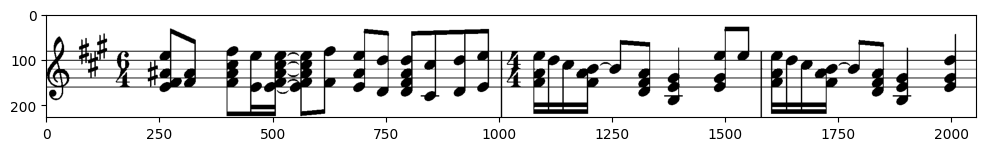

In [ ]:
music = # your binarization
plt.figure(figsize=(12, 3))
plt.imshow(music, cmap='gray', vmin=0, vmax=255);

In [ ]:
kernel = # your kernel
notes = cv2.morphologyEx(cv2.bitwise_not(music), cv2.MORPH_OPEN, kernel)
kernel = # your kernel
stand = cv2.morphologyEx(cv2.bitwise_not(music), cv2.MORPH_OPEN, kernel)

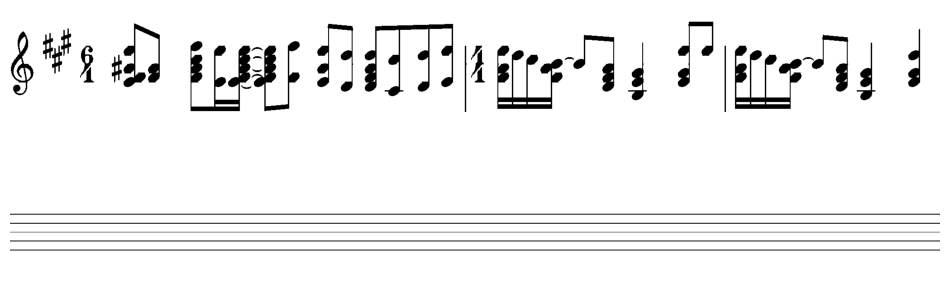

In [ ]:
_, axes = plt.subplots(nrows=2, figsize=(12, 4))
axes[0].imshow(cv2.bitwise_not(notes), cmap='gray')
axes[0].axis('off')
axes[1].imshow(cv2.bitwise_not(stand), cmap='gray')
axes[1].axis('off')
plt.show()